In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import rasterio as rio
from glob import glob
import os, sys
import itertools


In [3]:
# get y variable names
y_var_dir = '../../../data/y_tiles/'
y_files = glob(y_var_dir + "/*.tif")
y_vars = set([os.path.basename(f).split('_')[0] for f in y_files])
y_vars

{'Arson', 'Campfire', 'Children', 'Debris', 'Equipment'}

In [4]:
# get the tile numbers
tiles = set([os.path.basename(f).split('_')[-1].split('.tif')[0] for f in y_files])
tiles

{'t1',
 't10',
 't100',
 't101',
 't102',
 't103',
 't104',
 't105',
 't106',
 't107',
 't108',
 't109',
 't11',
 't110',
 't111',
 't112',
 't4',
 't8',
 't82',
 't87'}

In [5]:
months = set([os.path.basename(f).split('_')[-2] for f in y_files])
months

{'1', '10', '11', '12', '2', '2008', '2013', '3', '4', '5', '6', '7', '8', '9'}

In [6]:
os.path.basename(y_files[43]).split('_')

['Arson', '1992', '12', 't109.tif']

In [25]:
# find the filenames where months==2008 because wtf?
bad_months_2008 = [f for f in y_files if os.path.basename(f).split('_')[-2] == '2008']
bad_months_2013 = [f for f in y_files if os.path.basename(f).split('_')[-2] == '2013']
bad_months_2008, bad_months_2013

(['../../../data/y_tiles\\Children_2008_t4.tif',
  '../../../data/y_tiles\\Children_2008_t8.tif'],
 ['../../../data/y_tiles\\Campfire_2013_t87.tif',
  '../../../data/y_tiles\\Children_2013_t1.tif',
  '../../../data/y_tiles\\Equipment_Use_2013_t82.tif'])

In [26]:
val_months = set([os.path.basename(f).split('_')[-2] for f in y_files if int(os.path.basename(f).split('_')[-2]) <=12])
val_months

{'1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9'}

In [82]:
val_years = set([os.path.basename(f).split('_')[-3] for f in y_files if (len(os.path.basename(f).split('_')) > 3)])
val_years

{'1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 'Use'}

In [74]:
combinations = list(itertools.product(tiles, val_months, val_years))
combinations

[('t102', '4', '1995'),
 ('t102', '4', '2004'),
 ('t102', '4', '1996'),
 ('t102', '4', '2003'),
 ('t102', '4', '1994'),
 ('t102', '4', '2011'),
 ('t102', '4', '2008'),
 ('t102', '4', '2014'),
 ('t102', '4', '2015'),
 ('t102', '4', '2001'),
 ('t102', '4', '2000'),
 ('t102', '4', '2010'),
 ('t102', '4', '1997'),
 ('t102', '4', '2013'),
 ('t102', '4', '2002'),
 ('t102', '4', '1992'),
 ('t102', '4', '1998'),
 ('t102', '4', '2006'),
 ('t102', '4', '2012'),
 ('t102', '4', '2009'),
 ('t102', '4', '2005'),
 ('t102', '4', '2007'),
 ('t102', '4', '1999'),
 ('t102', '4', '1993'),
 ('t102', '11', '1995'),
 ('t102', '11', '2004'),
 ('t102', '11', '1996'),
 ('t102', '11', '2003'),
 ('t102', '11', '1994'),
 ('t102', '11', '2011'),
 ('t102', '11', '2008'),
 ('t102', '11', '2014'),
 ('t102', '11', '2015'),
 ('t102', '11', '2001'),
 ('t102', '11', '2000'),
 ('t102', '11', '2010'),
 ('t102', '11', '1997'),
 ('t102', '11', '2013'),
 ('t102', '11', '2002'),
 ('t102', '11', '1992'),
 ('t102', '11', '1998'),

In [62]:
class yDatasetSingleVar(Dataset):
    """Dataset class for ignition types (Y var)"""
    
    def __init__(self, data_dir, transform=None, ig_type='Arson'):
        """ 
        Args:
            data_dir(string): the folder containing the image files
            transform (callable, optional): Optional transform to  be applied to image data
            ig_types (iterable, optional): types of ignition rasters to include 
        """
        assert os.path.exists(data_dir)
        
        self.data_dir = data_dir
        self.transform = transform
        self.ig_types = ig_type # should have a default...
        self.val_months = set([os.path.basename(f).split('_')[-2] for f in y_files if int(os.path.basename(f).split('_')[-2]) <=12])
        self.tile_nums = set([os.path.basename(f).split('_')[-1].split('.tif')[0] for f in y_files])
        self.files = glob(data_dir + "/*{}*.tif".format(ig_type))
        self.month_tile = itertools.product(self.val_months, self.tile_nums)
        self.fi = None
        
        ## could also set up a set of variable names if specifying it in the constructor proves difficult
        #y_vars = set([os.path.basename(f).split('_')[0] for f in y_files])
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <ig_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        fi = self.files[idx] 
        print(fi)
        with rio.open(fi) as src:
            img_arr = src.read(1)
        
        print(img_arr.shape)
        
        if self.transform is not None:
            return self.transform(torch.from_numpy(img_arr))   
        else:
            return torch.from_numpy(img_arr)
        
        
    def __len__(self):
        return len(self.files)

In [94]:
test_single_var = yDatasetSingleVar(y_var_dir, ig_type='Campfire') # variable is Arson by default

In [95]:
test_single_var[1000] > 0

../../../data/y_tiles\Campfire_1997_12_t106.tif
(448, 320)


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

../../../data/y_tiles\Campfire_1996_12_t1.tif
(320, 320)


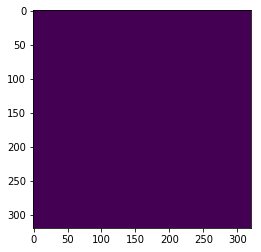

In [72]:
from matplotlib import pyplot as plt
plt.imshow(test_single_var[800])
plt.show()


In [91]:
class yDatasetMultiVar(Dataset):
    """Dataset class for ignition types (Y var)"""
    
    def __init__(self, data_dir, transform=None, ig_types=['Arson', 'Campfire']):
        """ 
        Args:
            data_dir(string): the folder containing the image files
            transform (callable, optional): Optional transform to  be applied to image data
            ig_types (iterable, optional): types of ignition rasters to include 
        """
        
        # some sanity checks
        assert os.path.exists(data_dir)
        assert len(ig_types) > 1
        val_ig_types = set([os.path.basename(f).split('_')[0] for f in glob(data_dir + '/*.tif')])
        for v in val_ig_types:
            assert v in list(val_ig_types)
        
        # initialize some attributes
        self.data_dir = data_dir
        self.transform = transform
        self.ig_types = ig_types # should have a default...
        self.val_months = set([os.path.basename(f).split('_')[-2] for f in y_files if int(os.path.basename(f).split('_')[-2]) <=12])
        
        # the filenaming is not consistent to get the years from the filename :(
        #self.val_years = set([os.path.basename(f).split('_')[-3] for f in y_files if (len(os.path.basename(f).split('_')) > 3)])
        self.val_years = list(range(1992,2016)) # 2015, since it is open-ended on the right
        
        self.tile_nums = set([os.path.basename(f).split('_')[-1].split('.tif')[0] for f in y_files])
        
        # get the files for ig_type[0]... need to assert that num_files for each ig_type is equal
        self.files = glob(data_dir + "/*{}*.tif".format(ig_types[0]))
        temp_list = []
        for ig_type in ig_types:
            files = glob(data_dir + "/{}*.tif".format(ig_type))
            temp_list.append(files)
        
        # this should ensure that the file numbers are equal
        for flist in temp_list[1:]:
            assert len(temp_list[0]) == len(flist)        
        
        # create an iterable for the __getitem__ method
        self.var_year_month_tile = itertools.product(self.ig_types, self.val_years, self.val_months, self.tile_nums)
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <ig_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        var, year, month, tile = self.var_year_month_tile[idx]
        files = [os.path.join(self.data_dir, '{}_{}_{}_{}.tif'.format(var, year, month, tile))]
        arrs = []
        for fi in files:
            with rio.open(fi) as src:
                arr = src.read(1)
            
            arrs.append(arr)
        img_arr = np.array(arrs)
        
        if self.transform is not None:
            return self.transform(torch.from_numpy(img_arr))   
        else:
            return torch.from_numpy(img_arr)
        
        
    def __len__(self):
        return len(self.files)

In [93]:
test_multi_var = yDatasetMultiVar(y_var_dir, ig_types=['Arson', 'Campfire']) # variable is Arson by default


AssertionError: 

In [90]:
for var in ['Arson1', 'Campfire']:
    print(var in y_vars)

False
True
